## Neural Posterior Estimation

This code shows how to build a neural posteior estimator with tensorflow and Masked Autoregressive Flows (a form of Normalising Flow, ). It is a bit more complicated than the other tensorflow codes we have looked at but stick with it and have a read. 

The goal here is to train a normalising flow to transform samples from the standard normal distribution to samples from a target distribution describing the parameters of a gaussian absorption feature where the transformation is conditional on the data.

As usual we will start by importing the necessary libraries.

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import re

# define tensorflow stuff
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions
tfb = tfp.bijectors

The normalising flows transform samples from one known analytic distribution (a standard normal distribution) to a more complex target distribution. The building block of a the normalsing flows used in this notebook at the Masked Autoencoder for Distribution Estimation or MADE neural netowrk. As when training any neural network we need to perform some normalisation.

Our training data consists of a set of sample simulations $D$ and corresponding parameters, $\theta$. Here we define some functions to normalise the distribution of parameters used to generate our simulated data. We will look at the normalisaiton of the simulations later in the code.

In practice a normalising flow will learn the target distribution better if it more closely matches the base distribution. In this example $\theta$ is a three dimensional distribution of parameters describing a gaussian absorption feature (approximating the 21-cm signal). Here we normalise the samples of $\theta$ on to by their minimum and maximum values and then push them on to the standard normal distribution.

We define a forward and inverse transformation for the samples. I also write a tensorflow train/test split function in this block too.

In [42]:
@tf.function(jit_compile=True)
def _forward_transform(x, min=0, max=1):
    r"""

    Tranforms input samples. Normalise between 0 and 1 and then tranform
    onto samples of standard normal distribution (i.e. base of
    tfd.TransformedDistribution).

    **parameters:**

        x: **array**
            | Samples to be normalised.

        min: **array or list**
            | Passed from the bijectors code. (mathematical
                description of their
                values...)

        max: **array or list**
            | Passed from the bijectors code.
                (mathematical description of their
                values...)

    """
    x = tfd.Uniform(min, max).cdf(x)
    x = tfd.Normal(0, 1).quantile(x)
    return x


@tf.function(jit_compile=True)
def _inverse_transform(x, min, max):
    r"""

    Tranforms output samples. Inverts the processes in
    ``forward_transofrm``.

    **parameters:**

        x: **array**
            | Samples to be normalised.

        min: **array or list**
            | Passed from the bijectors code.
                (mathematical description of their
                values...)

        max: **array or list**
            | Passed from the bijectors code.
                (mathematical description of their
                values...)

    """
    x = tfd.Normal(0, 1).cdf(x)
    x = tfd.Uniform(min, max).quantile(x)
    return x


def pure_tf_train_test_split(a, b, test_size=0.2):

    """
    Splitting data into training and testing sets. Function is equivalent
    to sklearn.model_selection.train_test_split but a and b
    are tensorflow tensors.

    **parameters:**

        a: **array**
            | Samples to be split.

        b: **array**
            | Weights to be split.

        test_size: **float**
            | Fraction of data to be used for testing.
    """

    idx = random.sample(range(len(a)), int(len(a)*test_size))

    a_train = tf.gather(a,
                        tf.convert_to_tensor(
                            list(set(range(len(a))) - set(idx))))
    b_train = tf.gather(b,
                        tf.convert_to_tensor(
                            list(set(range(len(b))) - set(idx))))
    a_test = tf.gather(a, tf.convert_to_tensor(idx))
    b_test = tf.gather(b, tf.convert_to_tensor(idx))

    return a_train, a_test, b_train, b_test

Here we define the training and test loss functions. For a normalising flow the loss is given by the mean log-likelihood of the training samples evaluated across the network. It is derived by trying to minimize the KL divergence between the true target distribution and the prediction from the flow for the same samples. Mathematically it looks like

$L = \sum_i \log p_{\phi}(x_i)$

where $\phi$ are the parameters of the normalising flow and $p_{\phi}(x_i)$ is the probability of the sample $x_i$ under the flow.

In [90]:
def make_bijector_kwargs(bijector, name_to_kwargs):

        if hasattr(bijector, 'bijectors'):
            return {b.name: 
                    make_bijector_kwargs(b, name_to_kwargs) 
                    for b in bijector.bijectors}
        else:
            for name_regex, kwargs in name_to_kwargs.items():
                if re.match(name_regex, bijector.name):
                    return kwargs
        return {}

@tf.function(jit_compile=True)
def _test_step(x, c_, maf):

    r"""
    This function is used to calculate the test loss value at each epoch
    for early stopping.
    """
    #c_ = tf.reshape(c_, (-1, 1))
    loss = -tf.reduce_mean(maf.log_prob(
            x, bijector_kwargs=make_bijector_kwargs(maf.bijector,
            {'maf.': {'conditional_input': c_}})
        ))
    return loss

@tf.function(jit_compile=True)
def _train_step(x, c_, maf):

    r"""
    This function is used to calculate the loss value at each epoch and
    adjust the weights and biases of the neural networks via the
    optimizer algorithm.
    """
    #c_ = tf.reshape(c_, (-1, 1))
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(maf.log_prob(
            x, bijector_kwargs=make_bijector_kwargs(maf.bijector, 
            {'maf.': {'conditional_input': c_}}
        )))
    gradients = tape.gradient(loss, maf.trainable_variables)
    optimizer.apply_gradients(
        zip(gradients,
            maf.trainable_variables))
    return loss


Next we generate a set of example gaussian absorption features. We sample our prior uniformly for the amplitude, width and central redshift of the signal. We generate 100,000 example signals for training and testing.

In [66]:
def gaussian(parameters):
    """a simple Gaussian function"""
    return -parameters[0] * \
        np.exp(-0.5*(z - parameters[1])**2/
               parameters[2]**2)

def prior(n):
    """a simple prior"""
    theta = np.ones((n, 3))
    theta[:, 0] = np.random.uniform(0.01, 0.3, n) # amplitude
    theta[:, 1] = np.random.uniform(10, 20, n) # mean
    theta[:, 2] = np.random.uniform(5, 10, n) # width
    return theta

z = np.linspace(5, 30, 100)[::-1]
n = 100000
theta = prior(n).astype(np.float32)
theta_min = np.array([0.01, 10, 5]).astype(np.float32)
theta_max = np.array([0.3, 20, 10]).astype(np.float32)
dims = theta.shape[1]
signals = np.array([gaussian(theta[i]) for i in range(n)])


Here we normalise the signals and perform a PCA compression on the training data.

In [86]:
norm_signals = (signals - signals.mean())/signals.std()
cov = np.cov(norm_signals, rowvar=False)
eig_vals, eig_vecs = np.linalg.eig(cov)
args = np.argsort(eig_vals)[::-1]
eig_vals = np.real(eig_vals[args])
eig_vecs = eig_vecs[:, args]

sum_eig_vals = np.sum(eig_vals)

explained_vairance = eig_vals/sum_eig_vals
cumulative_explained_variance = np.cumsum(explained_vairance)
ncomponents = len(cumulative_explained_variance[cumulative_explained_variance < 1 - 1e-5])

pca = np.real(np.dot(norm_signals, eig_vecs[:, :ncomponents])).astype(np.float32)
conditional = (pca - pca.mean())/pca.std()
important_eig_vecs = eig_vecs[:, :ncomponents]

conditional_dims = conditional.shape[1]

In [89]:
optimizer = tf.keras.optimizers.legacy.Adam(
                learning_rate=1e-3)

mades = [tfb.AutoregressiveNetwork(
            params=2,
            hidden_units=[50, 50],
            event_shape=(dims,),
            conditional=True,
            conditional_event_shape=(conditional_dims,),
            activation="sigmoid",
            dtype=np.float32
        ) for i in range(3)]

bij = tfb.Chain([tfb.MaskedAutoregressiveFlow(made, name='maf'+str(i))
                        for i,made in enumerate(mades)])

base = tfd.Blockwise(
            [tfd.Normal(loc=0, scale=1)
            for _ in range(dims)])

# make the transformed distribution
maf = tfd.TransformedDistribution(
    distribution=base,
    bijector=bij,
)

100%|██████████| 1000/1000 [01:41<00:00,  9.85it/s]


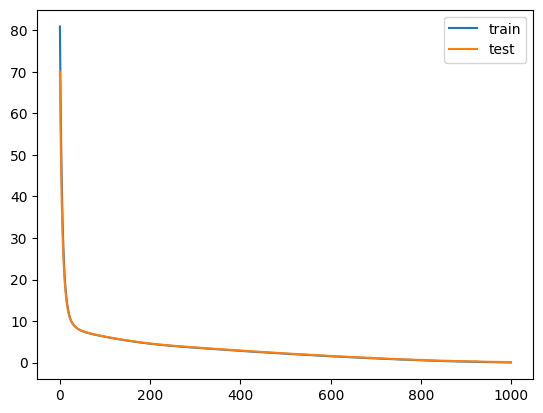

In [91]:
epochs = 1000


phi = _forward_transform(theta, theta_min, theta_max)
mask = np.isfinite(np.sum(phi, axis=1))
phi = phi[mask]
conditional = conditional[mask]

phi_train, phi_test, conditional_train, conditional_test = \
    pure_tf_train_test_split(phi, conditional, test_size=0.2)

loss_history = []
test_loss_history = []
c = 0
for i in tqdm.tqdm(range(epochs)):
    loss = _train_step(phi_train, conditional_train, maf)
    loss_history.append(loss)

    test_loss_history.append(_test_step(phi_test, conditional_test, maf))

    c += 1
    if i == 0:
        minimum_loss = test_loss_history[-1]
        minimum_epoch = i
        minimum_model = None
    else:
        if test_loss_history[-1] < minimum_loss:
            minimum_loss = test_loss_history[-1]
            minimum_epoch = i
            minimum_model = maf.copy()
            c = 0
    if minimum_model:
        if c == round((epochs/100)*2):
            print('Early stopped. Epochs used = ' + str(i) +
                    '. Minimum at epoch = ' + str(minimum_epoch))
            maf = minimum_model.copy()
            break

plt.plot(loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend()


/var/folders/pk/s11gmpgj1_d0jt1ykgfx7rt80000gn/T/ipykernel_3097/1501709202.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  pca_components = np.real(np.dot(true_data, important_eig_vecs).astype(np.float32)).astype(np.float32)


[-1.3571632  -0.49477696  1.2016191   0.10578937 -0.2691547 ]


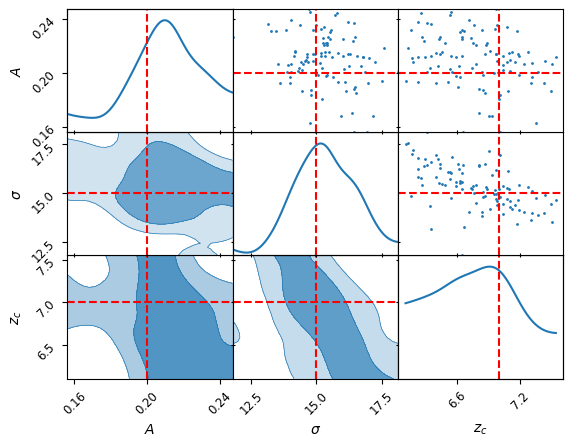

In [97]:
#@tf.function(jit_compile=True)
def __call__(u, c_):
    r"""

    This function is used when calling the MAF class to transform
    samples from the unit hypercube to samples on the MAF.

    **Parameters:**

        u: **numpy array**
            | Samples on the uniform hypercube.

    """

    if u.dtype != tf.float32:
        u = tf.cast(u, tf.float32)
    
    length = u.shape[0]

    x = _forward_transform(u)
    bijector_kwargs = make_bijector_kwargs(bij, 
                {'maf.': {'conditional_input': c_}})
    x = bij.forward(x, **bijector_kwargs)
    x = _inverse_transform(x, theta_min, theta_max)

    return x

u = np.random.uniform(0, 1, (100, 3)).astype(np.float32)
true_params = [0.2, 15, 7]
true_data = gaussian(true_params)
true_data = (true_data - signals.mean())/signals.std()
pca_components = np.real(np.dot(true_data, important_eig_vecs).astype(np.float32)).astype(np.float32)
pca_components = (pca_components - pca.mean())/pca.std()
print(pca_components)
samples = __call__(u, pca_components)
samples = samples.numpy()

from anesthetic import MCMCSamples

samples = MCMCSamples(samples, columns=[r'$A$', r'$\sigma$', r'$z_c$'])
axes = samples.plot_2d()
axes.axlines({r'$A$': 0.2, r'$\sigma$': 15, r'$z_c$': 7}, ls='--', c='r')
